# Classify land/water on Sentinel-1 and extract shorelines

## Load packages

In [1]:
%matplotlib inline

import os
os.environ['USE_PYGEOS'] = '0'
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from dea_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats
from dea_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from coastlines.raster import tide_cutoffs,load_tidal_subset
from coastlines.vector import points_on_line, annual_movements, calculate_regressions

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum, threshold_otsu
from skimage.morphology import binary_closing, disk,diameter_closing
from datacube.utils.cog import write_cog

import itertools
from deafrica_tools.classification import predict_xr
import pickle

import warnings
warnings.filterwarnings("ignore")

from modules import lee_filter,filter_by_tide_height,load_s1_by_orbits,process_features_s1,collect_training_samples

## Set up a Dask cluster

In [2]:
client = create_local_dask_cluster(return_client=True)

<Client: 'tcp://127.0.0.1:43699' processes=1 threads=4, memory=26.21 GiB>

## Connect to the datacube

In [3]:
dc = datacube.Datacube(app="Sentinel-1 shoreline extraction")

In [4]:
# Define areas of interest: Madagarscar,Comoros
locations={'Madagascar_west':(-17.474,43.924),
           'Madagascar_south':(-25.572,45.538),
           'Tanzania':(-6.32,39.280),
           'Kenya':(-4.025,39.725),
           'Comoros':(-12.4,43.736)
          }
location_name=list(locations.keys())[4]
location=locations[location_name]
lat=location[0]
lon=location[1]

# Combine central lat,lon with buffer to get area of interest
buffer = 0.04
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

# Set the range of dates for the analysis, time step and tide range
time_range = ('2018', '2021')
time_step = '1Y'
tide_range = (0.25, 0.75)

# whether to apply orbit filtering
s1_orbit_filtering=True

# whether to implement Lee filtering on Sentinel-1 data
lee_filtering=True

# Lee filtering size
filter_size=2

## View the selected location

In [5]:
display_map(x=lon_range, y=lat_range)

## Load and process Sentinel-1 data

In [6]:
# query S1 data
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vh','vv','mask','area'], # loading vh for experiement
    'resolution': (-20, 20),
    'output_crs':"EPSG:6933",
    'group_by':'solar_day',
    'dask_chunks':{'time': 1}
}

# load s1 by orbit
S1=load_s1_by_orbits(dc,query)

# per-pixel tide modelling and filtering
print('Tide modelling and filtering for Sentinel-1...')
S1_filtered=filter_by_tide_height(S1,tide_centre=0.0)

# preprocess S1 and extract features
ds_summaries_s1=process_features_s1(S1_filtered,filter_size=filter_size,
                                s1_orbit_filtering=s1_orbit_filtering,time_step=time_step)

# Rename each image by year
ds_summaries_s1['time'] = ds_summaries_s1.time.dt.year
ds_summaries_s1 = ds_summaries_s1.rename(time='year')

print(ds_summaries_s1)


Querying and loading Sentinel-1 ascending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 92 time steps as a dask array

Querying and loading Sentinel-1 descending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 99 time steps as a dask array
Tide modelling and filtering for Sentinel-1...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 191/191 [00:01<00:00, 169.10it/s]


Applying Lee filtering using filtering size of 2 pixels...

Filtering Sentinel-1 product by orbit...


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Calculating features for Sentinel-1
Generate temporal composites...
<xarray.Dataset>
Dimensions:      (year: 4, y: 500, x: 387)
Coordinates:
  * y            (y) float64 -1.565e+06 -1.565e+06 ... -1.575e+06 -1.575e+06
  * x            (x) float64 4.216e+06 4.216e+06 ... 4.224e+06 4.224e+06
    spatial_ref  int32 6933
  * year         (year) int64 2018 2019 2020 2021
Data variables:
    vh           (year, y, x) float32 -18.76 -19.31 -21.79 ... -34.42 -34.74
    vv           (year, y, x) float32 -12.44 -13.25 -19.53 ... -16.61 -16.66
    vv_a_vh      (year, y, x) float32 -31.2 -32.56 -41.32 ... -50.89 -50.92
    vv_m_vh      (year, y, x) float32 6.324 6.057 2.261 ... 16.76 16.2 16.17
    area         (year, y, x) float32 1.058 1.337 1.518 ... 1.504 1.502 1.503
    vh_std       (year, y, x) float32 1.56 1.516 1.19 ... 4.349 4.57 3.505
    vv_std       (year, y, x) float32 2.56 2.399 2.002 2.471 ... 7.117 7.306 inf
    vv_a_vh_std  (year, y, x) float32 4.12 3.915 3.192 3.074 ... 9.338 10.

## Load and process Sentinel-2 data

In [7]:
# query S2
print('\nQuerying Sentinel-2 data...')
query.update({'measurements': ['red', 'green', 'blue', 'swir_1','nir']})
S2 = load_ard(dc=dc,
              products=['s2_l2a'],
              resampling='bilinear',
              min_gooddata=0.8,
              align=(10, 10),
              mask_filters=[("opening", 2), ("dilation", 5)],
              **query)

# Calculate S2 water index
S2 = calculate_indices(S2, index='MNDWI', satellite_mission='s2')

# per-pixel tide modelling and filtering
print('Tide modelling and filtering for Sentinel-2...')
S2_filtered=filter_by_tide_height(S2,tide_centre=0.0)

# median of S2
ds_summaries_s2 = (S2_filtered
                .resample(time=time_step)
                .median('time')
                .compute()
                    )

# Rename each image by year
ds_summaries_s2['time'] = ds_summaries_s2.time.dt.year
ds_summaries_s2 = ds_summaries_s2.rename(time='year')

print(ds_summaries_s2)


Querying Sentinel-2 data...
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 401 out of 578 time steps with at least 80.0% good quality pixels
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 401 time steps as a dask array
Tide modelling and filtering for Sentinel-2...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 401/401 [00:02<00:00, 176.61it/s]


<xarray.Dataset>
Dimensions:      (year: 4, y: 500, x: 387)
Coordinates:
  * y            (y) float64 -1.565e+06 -1.565e+06 ... -1.575e+06 -1.575e+06
  * x            (x) float64 4.216e+06 4.216e+06 ... 4.224e+06 4.224e+06
    spatial_ref  int32 6933
  * year         (year) int64 2018 2019 2020 2021
Data variables:
    red          (year, y, x) float32 601.5 446.0 410.0 ... 111.0 125.0 141.0
    green        (year, y, x) float32 706.0 539.0 469.0 ... 179.0 172.0 168.0
    blue         (year, y, x) float32 536.0 454.0 410.0 ... 296.0 290.0 284.0
    swir_1       (year, y, x) float32 1.019e+03 346.5 203.0 ... 91.0 86.0 89.0
    nir          (year, y, x) float32 1.479e+03 260.5 198.0 ... 102.0 104.0 84.0
    MNDWI        (year, y, x) float32 -0.1211 0.1717 0.3506 ... 0.2929 0.2881
    tide_m       (year, y, x) float32 0.1643 0.1643 0.1643 ... 0.1034 0.1034
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Plot temporal composites

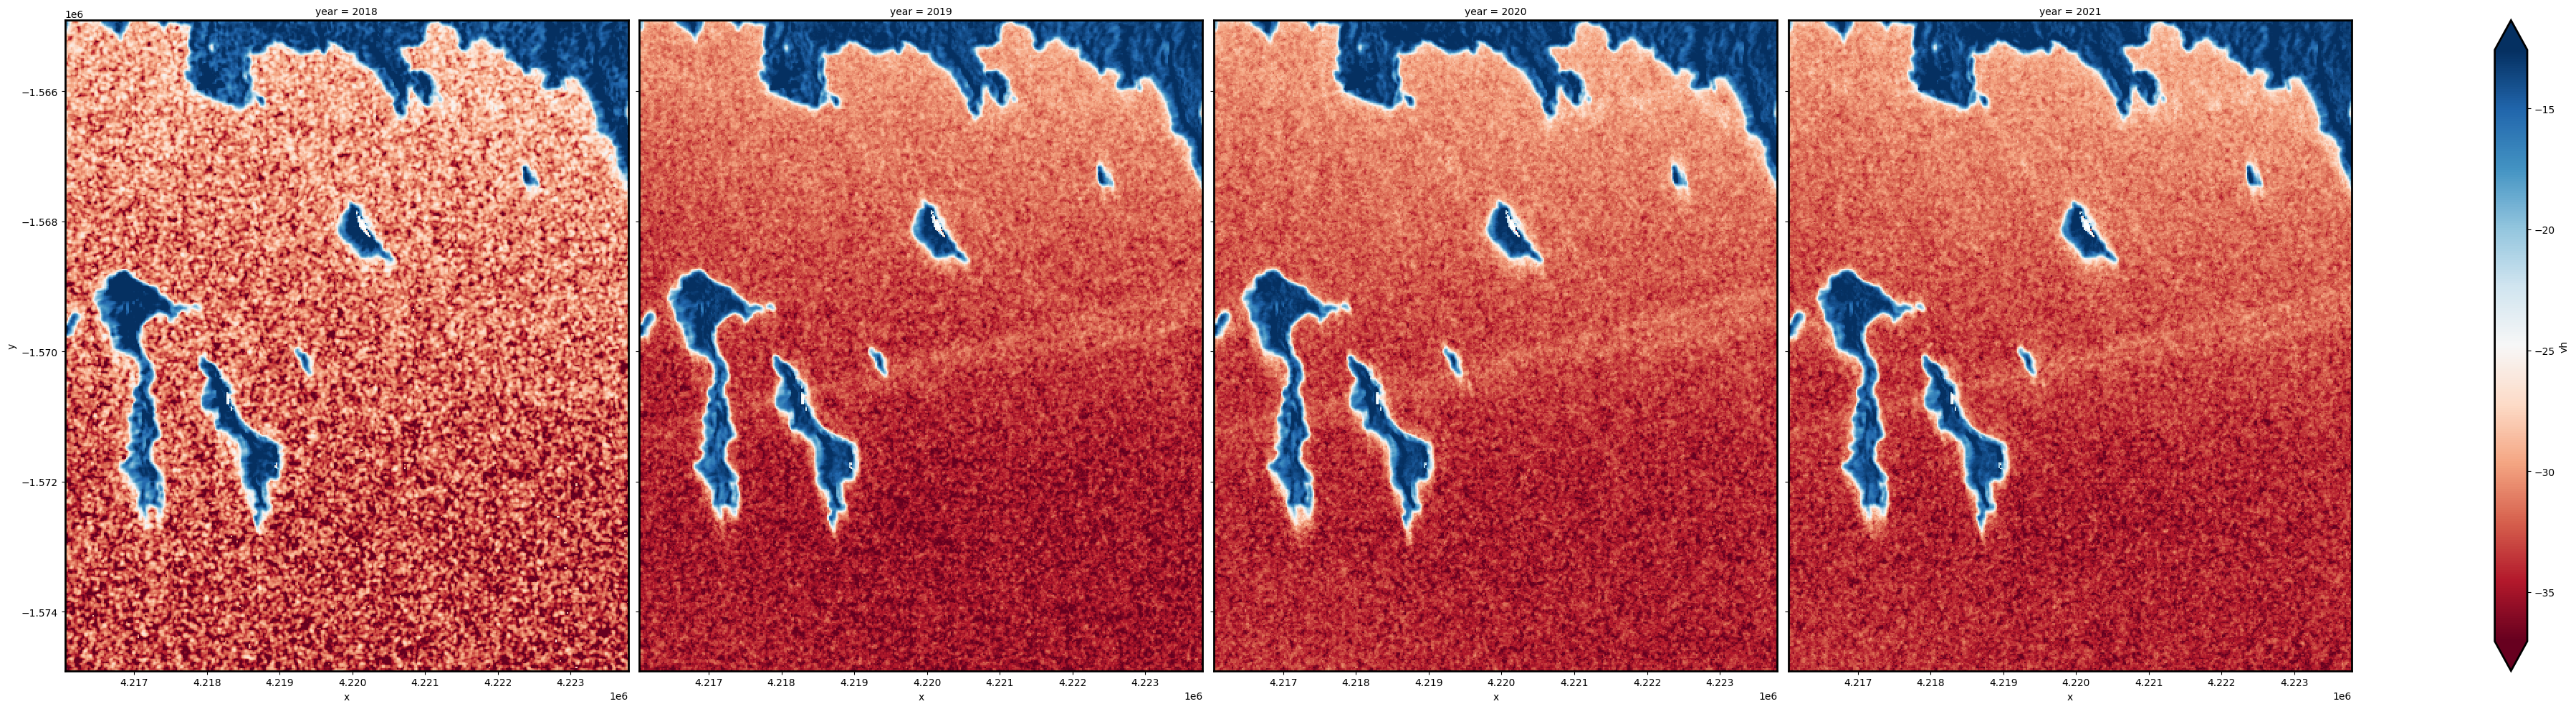

In [8]:
# Plot vh
ds_summaries_s1.vh.plot(col='year',
                       cmap='RdBu',
                       col_wrap=4,
                       robust=True, size=10)
plt.savefig('s1_annual_medians_vh_{}.png'.format(location_name))

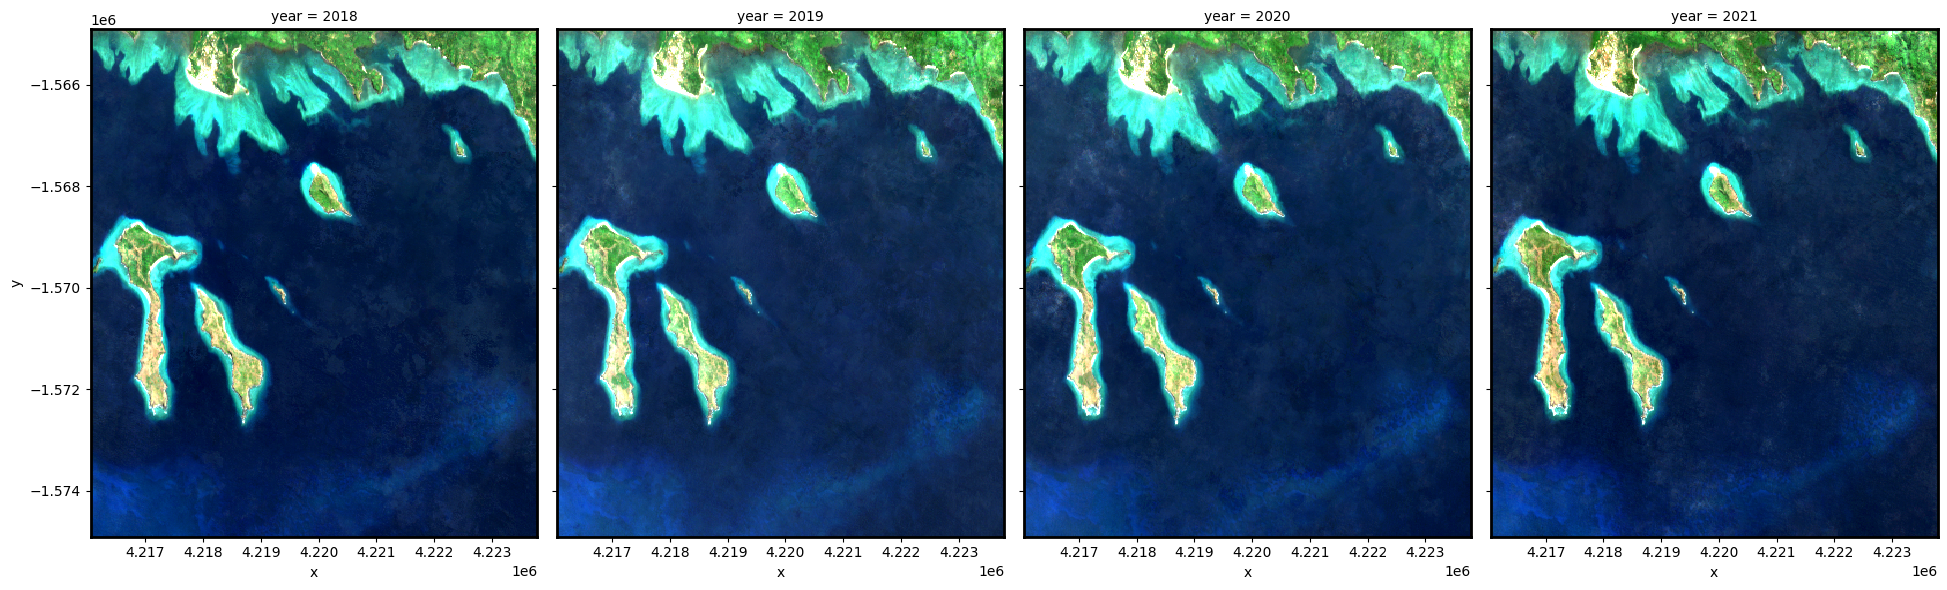

In [9]:
# Plot Sentinel-2
# ds_summaries_s2.MNDWI.plot(col='year',
#                        cmap='RdBu',
#                        col_wrap=4,
#                        robust=True, size=10)
rgb(ds_summaries_s2, col='year')
plt.savefig('s2_annual_medians_rgb_{}.png'.format(location_name))

### Thresholding of Sentinel-1 data (for comparison)

In [10]:
# minimum thresholding
threshold = threshold_minimum(ds_summaries_s1.vh.values[~np.isnan(ds_summaries_s1.vh.values)])
# otsu thresholding
threshold_o = threshold_otsu(ds_summaries_s1.vh.values[~np.isnan(ds_summaries_s1.vh.values)])
print('threshold identified by minimum thresholding method: ',threshold)
print('threshold identified by otsu thresholding method: ', threshold_o)

threshold identified by minimum thresholding method:  -18.041176
threshold identified by otsu thresholding method:  -23.856052


## Apply the classification model

### Load the model

In [11]:
model_name='rf_model_'+location_name
with open (model_name, 'rb') as file:
    rf = pickle.load(file)

### Predict each year

In [12]:
# apply to each year
predicted=[]
for i in range(ds_summaries_s1.dims['year']):
    ds_s1_year=ds_summaries_s1.isel(year=i)
    predicted_year = predict_xr(rf,ds_s1_year,proba=True,persist=False,clean=True).assign_coords(year=ds_s1_year.year.values).expand_dims('year')
    predicted.append(predicted_year)
predicted=xr.concat(predicted,dim='year')
print(predicted)

predicting...
   probabilities...
predicting...
   probabilities...
predicting...
   probabilities...
predicting...
   probabilities...
<xarray.Dataset>
Dimensions:        (x: 387, y: 500, year: 4)
Coordinates:
  * x              (x) float64 4.216e+06 4.216e+06 ... 4.224e+06 4.224e+06
  * y              (y) float64 -1.565e+06 -1.565e+06 ... -1.575e+06 -1.575e+06
    spatial_ref    int32 6933
  * year           (year) int64 2018 2019 2020 2021
Data variables:
    Predictions    (year, y, x) float64 0.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Probabilities  (year, y, x) float64 54.5 75.0 95.5 ... 100.0 100.0 83.0
Attributes:
    grid_mapping:  spatial_ref


### Plot predictions and probabilities

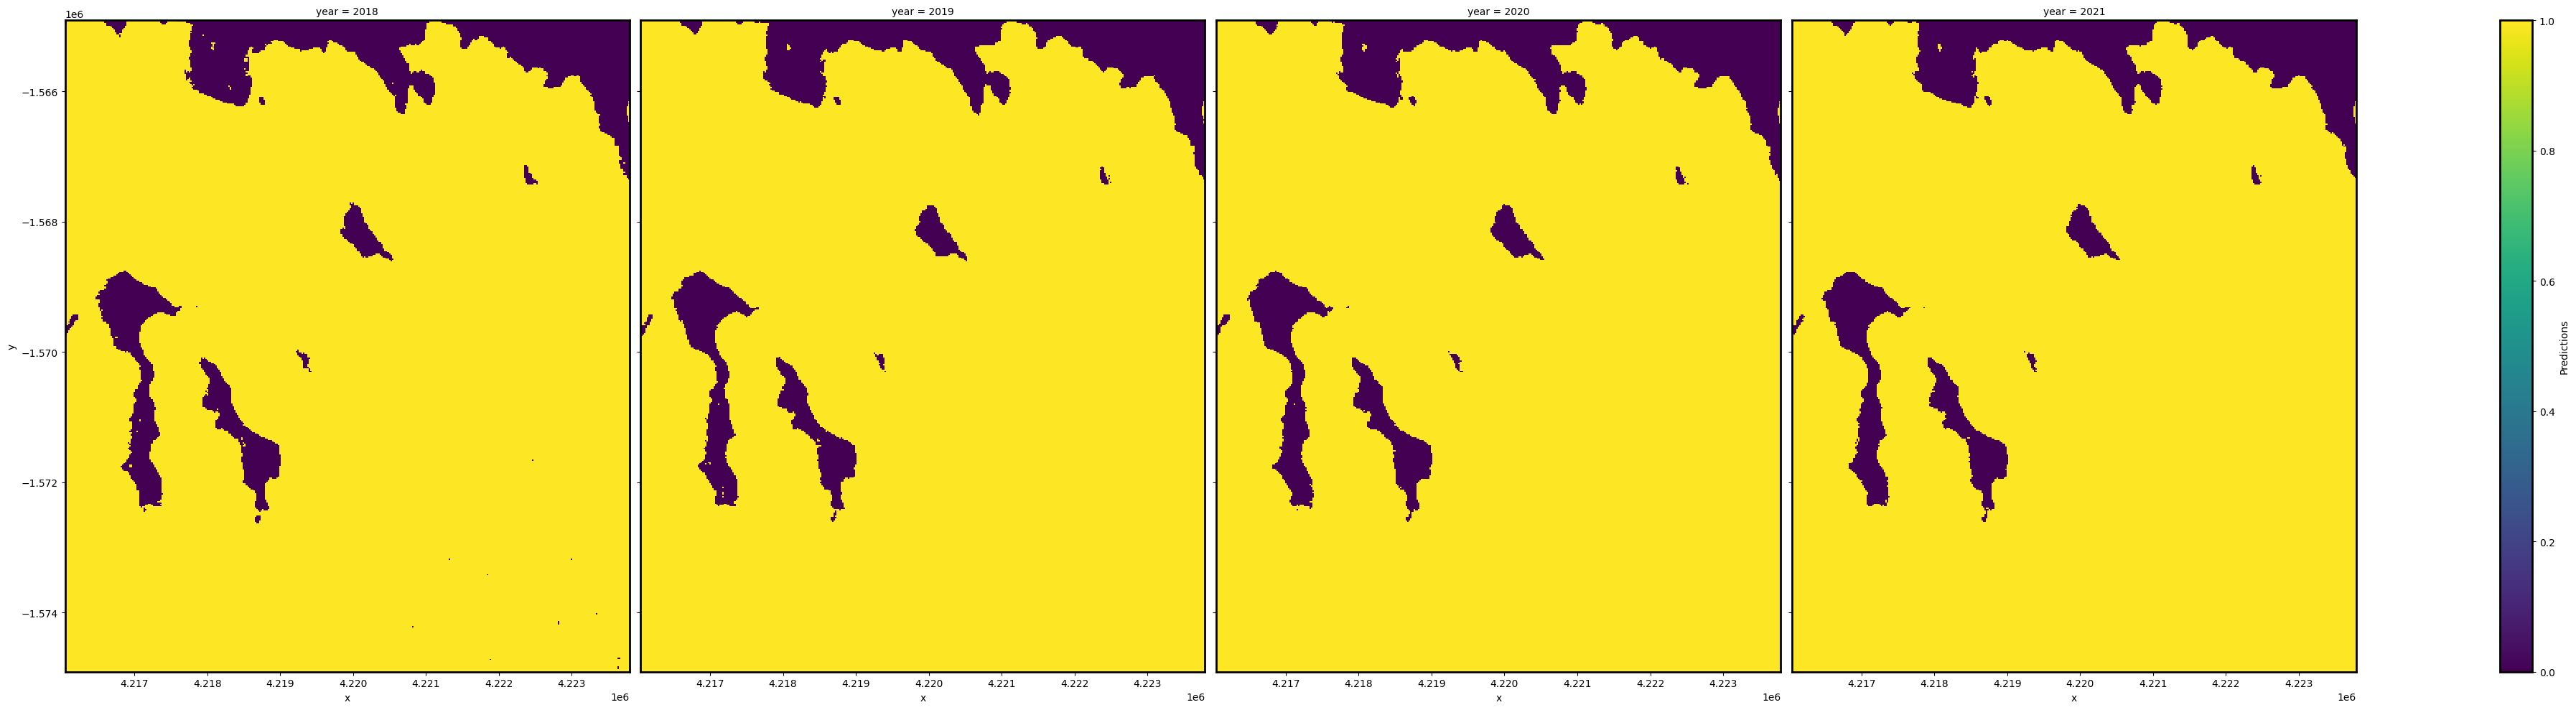

In [13]:
predicted.Predictions.plot(col='year',
                           cmap='viridis',
                           col_wrap=4,
                           robust=True, 
                           size=10)
plt.savefig('predictions_s1_unfiltered_{}.png'.format(location_name))

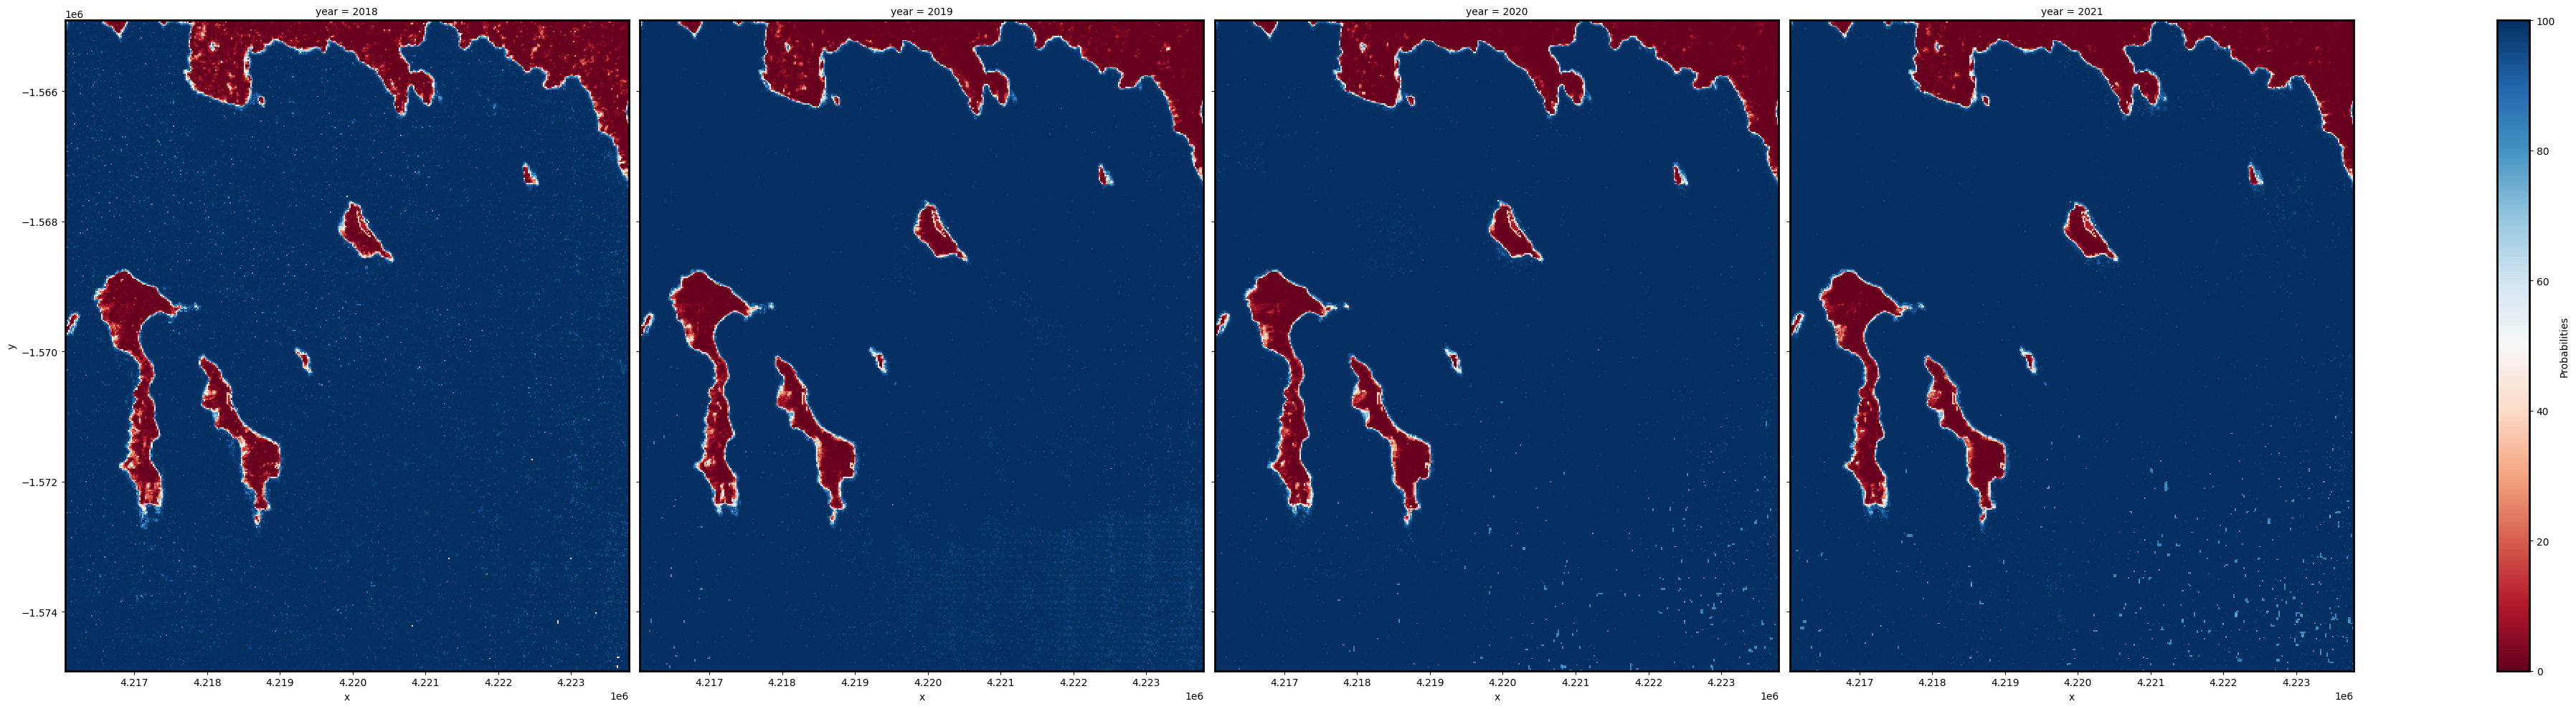

In [14]:
# covert the overall classification probabilities to water probabilities
predicted['Probabilities']=predicted.Probabilities.where(predicted.Predictions==1,100-predicted.Probabilities)
predicted.Probabilities.plot(col='year',
                           cmap='RdBu',
                           col_wrap=4,
                           robust=True, 
                           size=10)
plt.savefig('probabilities_s1_unfiltered_{}.png'.format(location_name))

### Spatial filtering of the predictions and probabilities

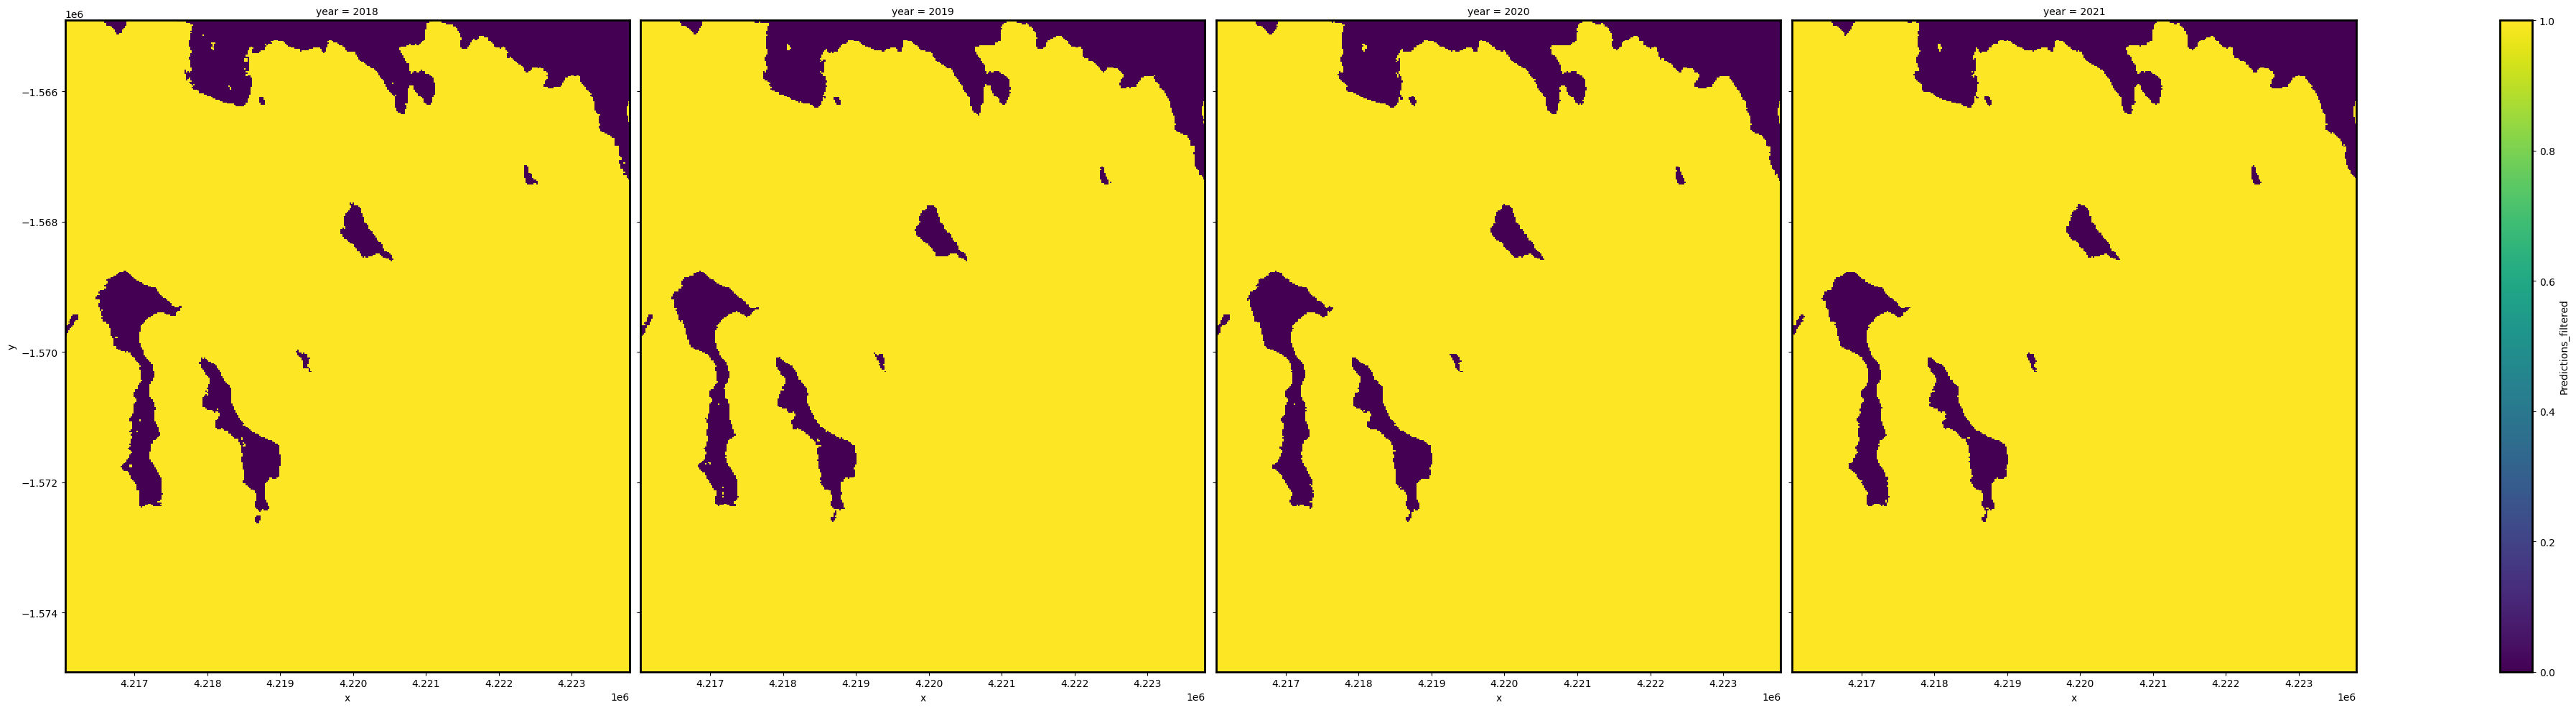

In [15]:
# predicted['Predictions_filtered']=xr.apply_ufunc(binary_closing, predicted.Predictions,disk(2))
predicted['Predictions_filtered']=xr.apply_ufunc(diameter_closing, predicted.Predictions,8)
predicted.Predictions_filtered.plot(col='year',
                           cmap='viridis',
                           col_wrap=4,
                           size=10)
plt.savefig('predictions_s1_filtered_{}.png'.format(location_name))

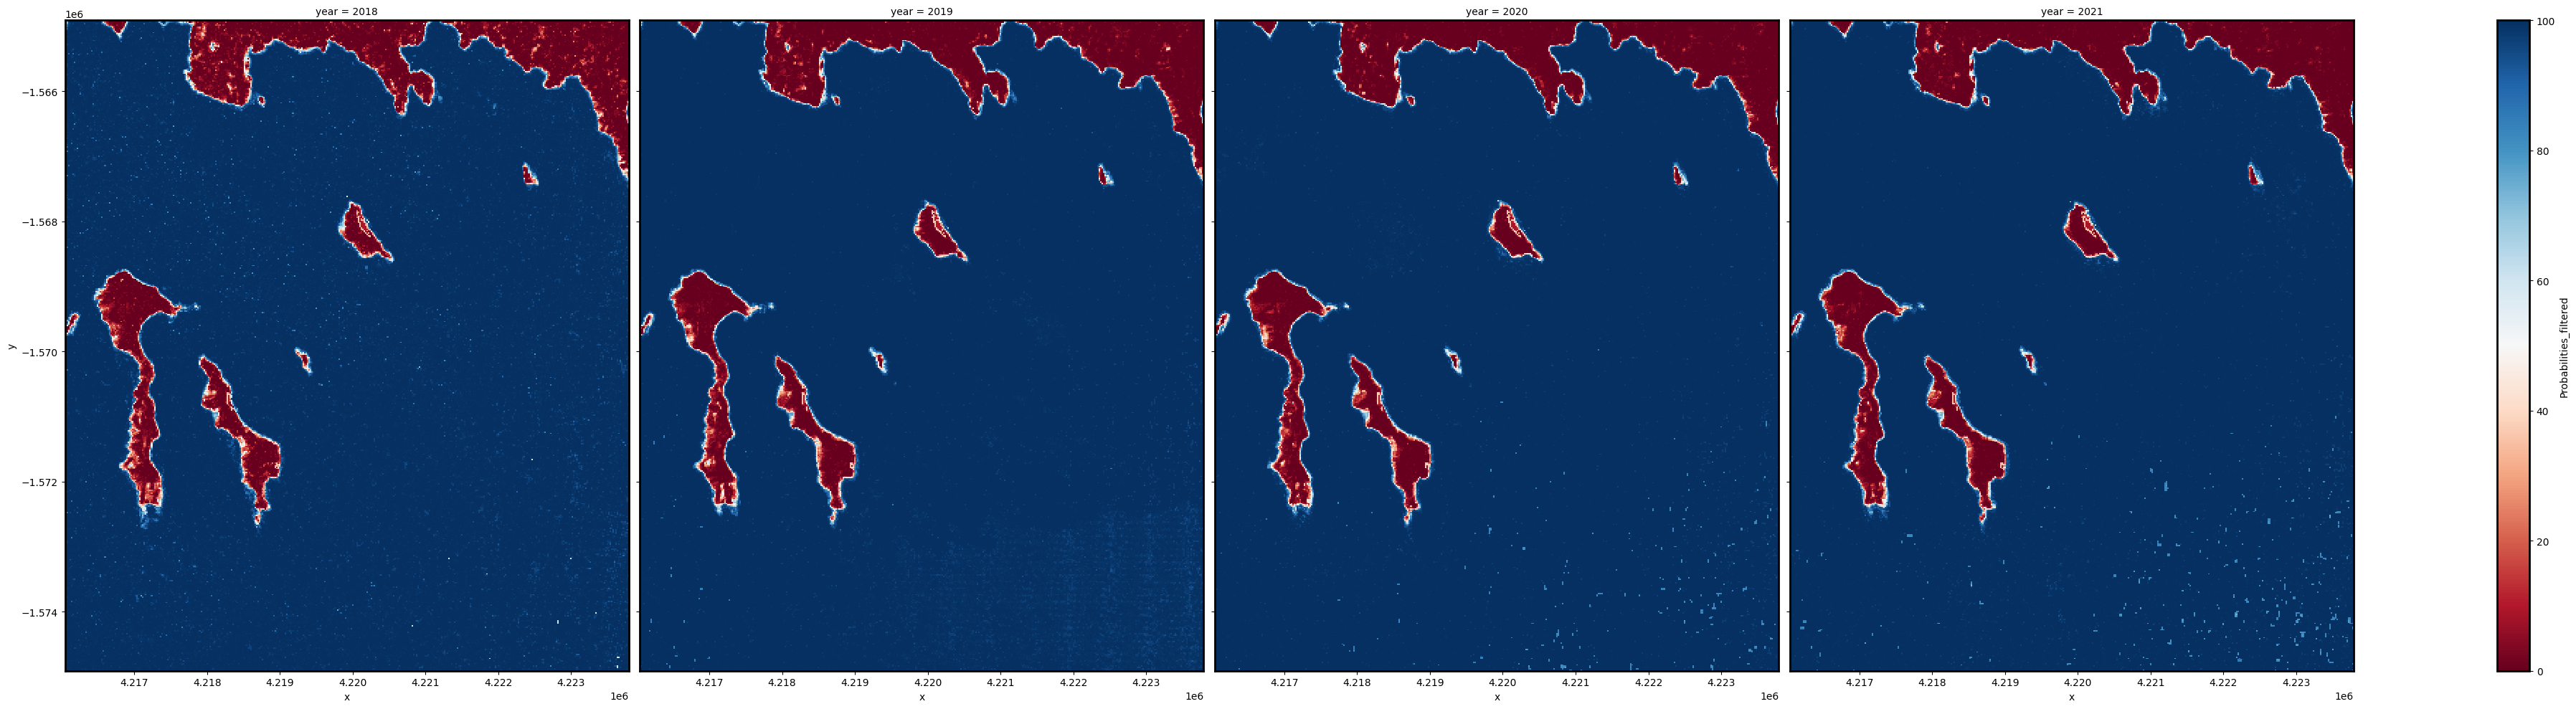

In [16]:
predicted['Probabilities_filtered']=predicted.Probabilities.where(predicted.Predictions_filtered==predicted.Predictions,
                                                                  100-predicted.Probabilities)
predicted.Probabilities_filtered.plot(col='year',
                           cmap='RdBu',
                           col_wrap=4,
                           robust=True, 
                           size=10)
plt.savefig('probabilities_s1_filtered_{}.png'.format(location_name))

### Plot classification results using thresholding (as comparison)

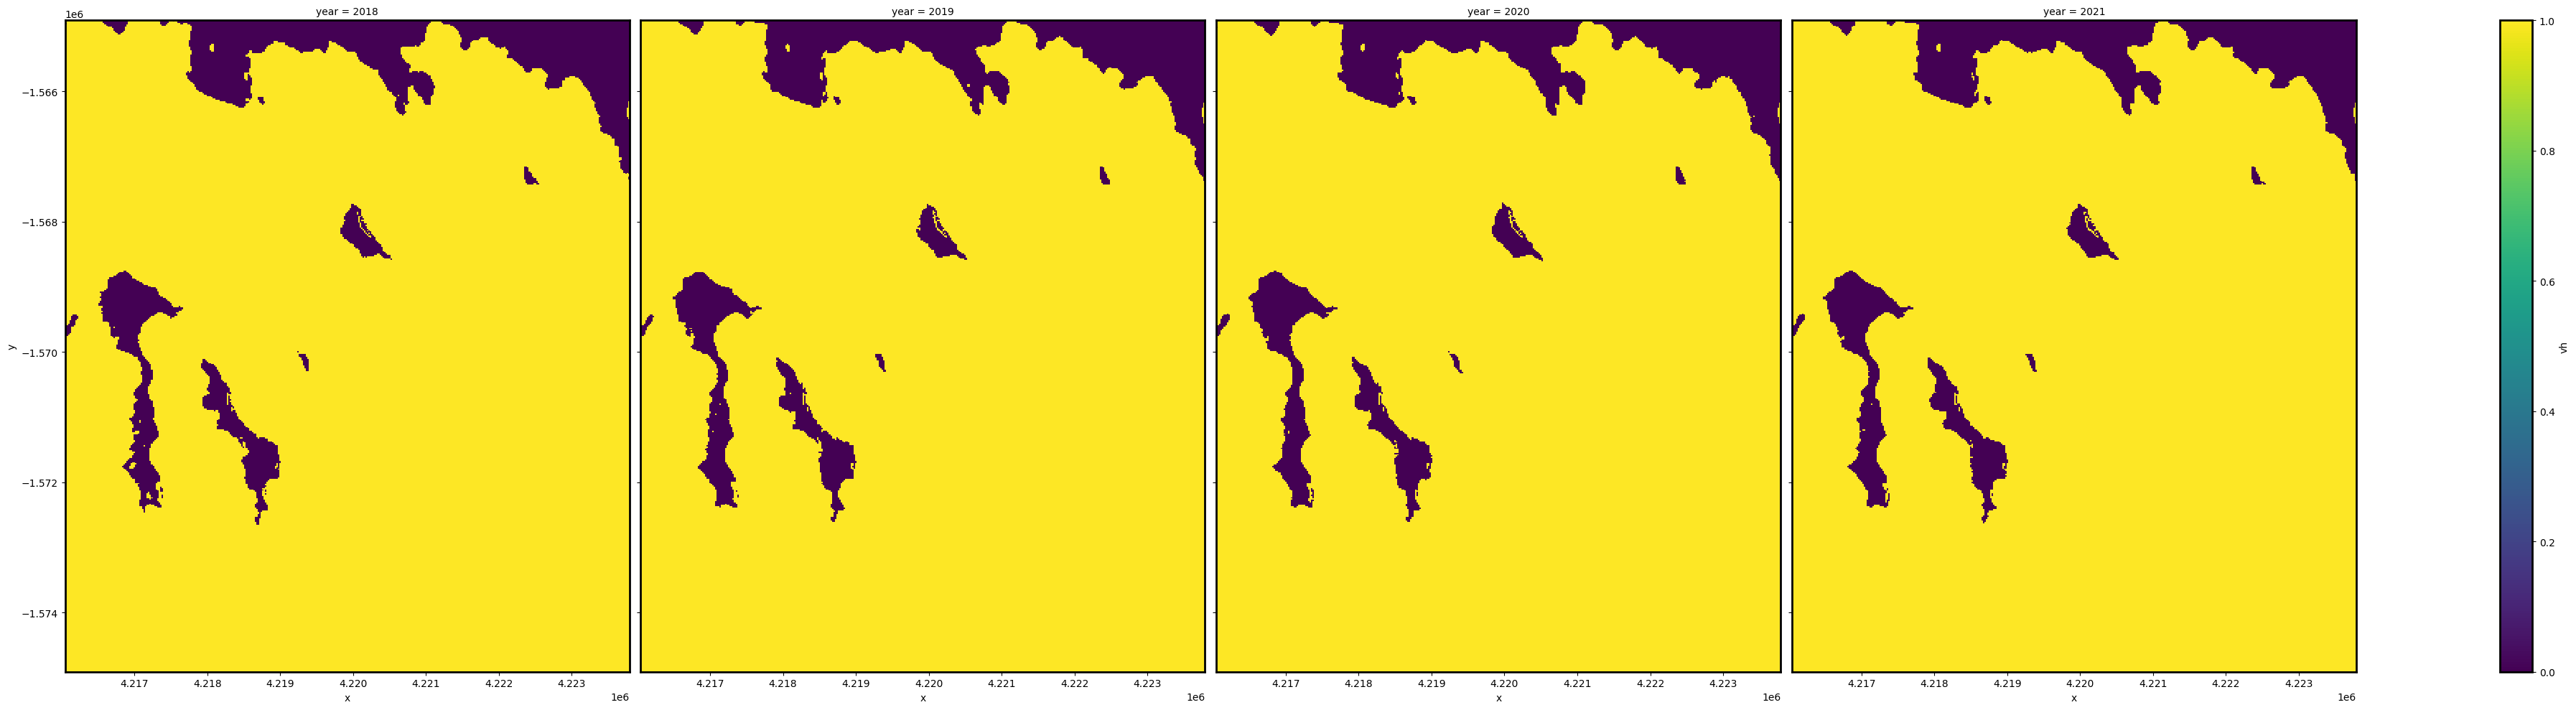

In [17]:
ds_summaries_s1_thresholded=ds_summaries_s1.vh<=threshold
ds_summaries_s1_thresholded.plot(col='year',
                           cmap='viridis',
                           col_wrap=4,
                           size=10)
plt.savefig('thresholding_s1_{}.png'.format(location_name))

### Plot Sentinel-2 classification results (for comparison)

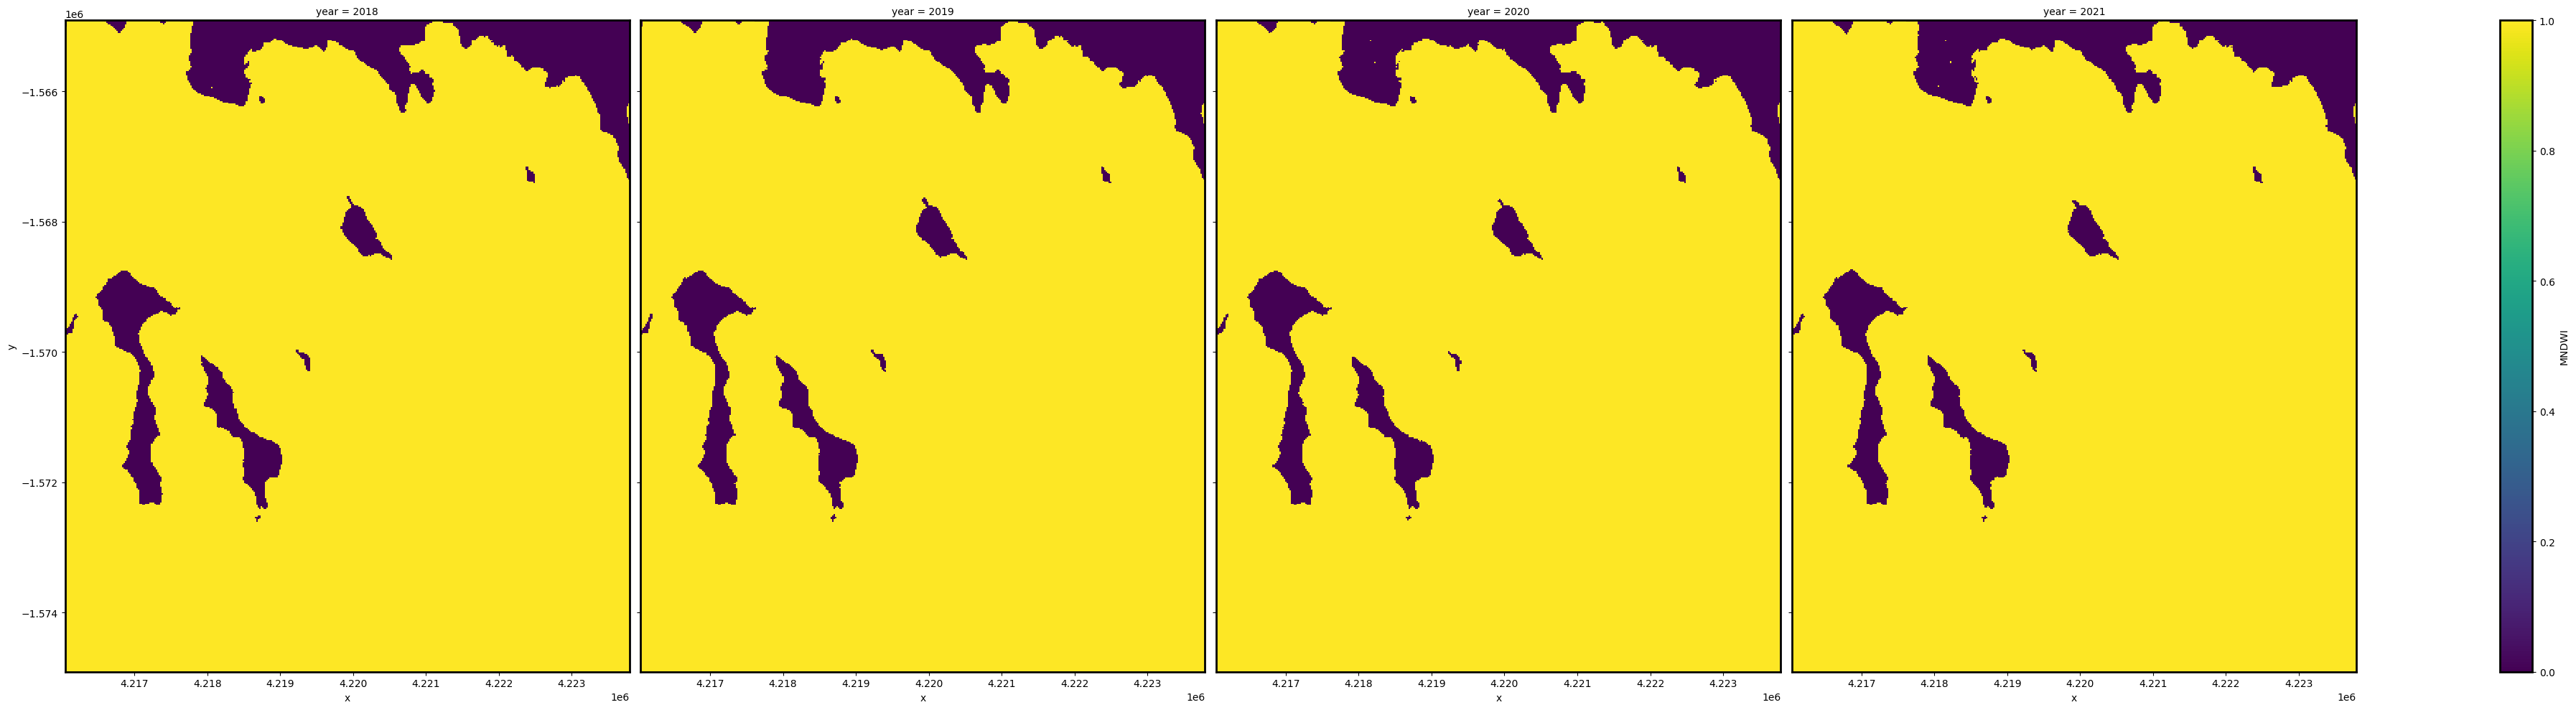

In [18]:
ds_summaries_s2_thresholded=ds_summaries_s2['MNDWI']>=0
ds_summaries_s2_thresholded.plot(col='year',
                           cmap='viridis',
                           col_wrap=4,
                           size=10)
plt.savefig('thresholding_s2_{}.png'.format(location_name))

## Extract shorelines

### Extract shorelines from prediction probabilities

In [19]:
# Extract waterline contours for the '0.5' probability:
# contour_gdf = subpixel_contours(da=predicted.Probabilities,
#                                 z_values=50,
#                                 dim='year',
#                                 crs=predicted.geobox.crs,
#                                 output_path=f'annual_shorelines_S1_supervised.geojson',
#                                 min_vertices=15).set_index('year')
contour_gdf = subpixel_contours(da=predicted.Probabilities_filtered,
                                z_values=50,
                                dim='year',
                                crs=predicted.geobox.crs,
                                output_path='annual_shorelines_S1_supervised_filtered_{}.geojson'.format(location_name),
                                min_vertices=15).set_index('year')

Operating in single z-value, multiple arrays mode
Writing contours to annual_shorelines_S1_supervised_filtered_Comoros.geojson


### Extract shorelines from thresholding method (for comparison)

In [20]:
contour_gdf_thresholding=subpixel_contours(da=ds_summaries_s1.vh,
                                z_values=threshold,
                                dim='year',
                                crs=predicted.geobox.crs,
                                output_path='annual_shorelines_S1_thresholding_{}.geojson'.format(location_name),
                                min_vertices=15).set_index('year')

Operating in single z-value, multiple arrays mode
Writing contours to annual_shorelines_S1_thresholding_Comoros.geojson


### Extract shorelines from Sentinel-2 data (for comparison)

In [21]:
contour_gdf_s2=subpixel_contours(da=ds_summaries_s2['MNDWI'],
                                z_values=0,
                                dim='year',
                                crs=predicted.geobox.crs,
                                output_path='annual_shorelines_S2_{}.geojson'.format(location_name),
                                min_vertices=15).set_index('year')

Operating in single z-value, multiple arrays mode
Writing contours to annual_shorelines_S2_Comoros.geojson


### Plot annual shorelines on an interactive map

In [22]:
# Plot shorelines on interactive map
contour_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

In [23]:
contour_gdf_thresholding.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

In [24]:
contour_gdf_s2.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

In [25]:
# Shut down Dask client now that we have processed the data we need
client.close()